Nessesary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define rotation/translation matrices

In [2]:
def Rx(q):
    T = np.array([[1, 0, 0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q), np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def dRx(q):
    T = np.array([[0, 0, 0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, 0, 0, 0]])
    return T


def Ry(q):
    T = np.array([[np.cos(q), 0, np.sin(q), 0],
                  [0, 1, 0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [0, 0, 0, 1]])
    return T


def dRy(q):
    T = np.array([[-np.sin(q), 0, np.cos(q), 0],
                  [0, 0, 0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [0, 0, 0, 0]])
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q), np.cos(q), 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [np.cos(q), -np.sin(q), 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def dTx(x):
    T = np.array([[0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])
    return T


def dTy(y):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]])
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]])
    return T


def dTz(z):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]])
    return T

Calculate FK and IK

In [3]:
def FK(q, theta, l):
    T = np.linalg.multi_dot([Tz(l[0]),
                             Rz(q[0]),
                             Rz(theta[0]),
                             Tz(q[1]),
                             Tz(theta[1]),
                             Ty(l[1]),
                             Ty(q[2]),
                             Ty(theta[2])])
    return T


def IK(end_points, link):
    x = end_points[0]
    y = end_points[1]
    z = end_points[2]

    q1 = np.arctan2(x, y)
    q2 = z - link[0]
    q3 = np.sqrt(y ** 2 + x ** 2) - link[1]

    q = np.array([q1, q2, q3])
    return q

Calculate jacobian

In [4]:
def JacobianForTheta(q, theta, l):
    T = FK(q, theta, l)
    T[0:3, 3] = 0
    T_inv = np.transpose(T)

    dT = np.linalg.multi_dot([Tz(l[0]),
                              Rz(q[0]),
                              dRz(theta[0]),
                              Tz(q[1]),
                              Tz(theta[1]),
                              Ty(l[1]),
                              Ty(q[2]),
                              Ty(theta[2])
                              ])

    dT = np.linalg.multi_dot([dT, T_inv])
    J1 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(l[0]),
                              Rz(q[0]),
                              Rz(theta[0]),
                              Tz(q[1]),
                              dTz(theta[1]),
                              Ty(l[1]),
                              Ty(q[2]),
                              Ty(theta[2])
                              ])

    dT = np.linalg.multi_dot([dT, T_inv])
    J2 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    dT = np.linalg.multi_dot([Tz(l[0]),
                              Rz(q[0]),
                              Rz(theta[0]),
                              Tz(q[1]),
                              Tz(theta[1]),
                              Ty(l[1]),
                              Ty(q[2]),
                              dTy(theta[2])
                              ])

    dT = np.linalg.multi_dot([dT, T_inv])
    J3 = np.vstack([dT[0, 3], dT[1, 3], dT[2, 3], dT[2, 1], dT[0, 2], dT[1, 0]])

    J = np.hstack([J1, J2, J3])
    return J

Noise randomizer

In [5]:
def getRandomNoise():
    return np.random.normal(loc=0, scale=1e-5)

Update joint stiffness

In [6]:
# Initial parameters
experiments = 30
points_per_experiment = 100

links_length = np.array([0.4, 0.1])
theta = np.array([0, 0, 0])

# Create stiffness matrix before calibration
JointStiffness = np.array([1e+6, 2e+6, 0.5e+6])
JointStiffness = np.diag(JointStiffness)

first_term = np.zeros((3, 3))
second_term = np.zeros(3)

for i in range(experiments):
    q_revolute = np.random.uniform(-np.pi, np.pi, 1)
    q_prismatic = np.random.uniform(0, 1, 2)
    q = np.hstack([q_revolute, q_prismatic])

    W = np.random.uniform(-1000, 1000, 6)

    jTheta = JacobianForTheta(q, theta, links_length)

    dt = np.linalg.multi_dot([jTheta, np.linalg.inv(JointStiffness), np.transpose(jTheta), W]) + getRandomNoise()

    jTheta = jTheta[0:3, :]
    dt = dt[0:3]
    W = W[0:3]

    A = np.zeros(jTheta.shape)

    for i_jac in range(jTheta.shape[1]):
        j = jTheta[:, i_jac]
        A[:, i_jac] = np.outer(j, j).dot(W)

    first_term = first_term + np.transpose(A).dot(A)
    second_term = second_term + np.transpose(A).dot(dt)

delta_x_hat = np.linalg.inv(first_term).dot(second_term)

stiffness = np.divide(1, delta_x_hat)
print("Recalculated joint stiffness: {}".format(stiffness))

# new stiffness matrix
JointStiffness = np.diag(stiffness)

Recalculated joint stiffness: [1094511.48480633 1985675.46331686  499370.50625935]


Calculate data for plots

In [7]:
W = np.array([-1000, -1000, -1000, 0, 0, 0])

x_center = y_center = 0
z_center = links_length[0]

alpha = np.linspace(0, 2 * np.pi, points_per_experiment)

# desired trajectory ( circle )
r = 10

X = x_center + r * np.cos(alpha)
Y = y_center + r * np.sin(alpha)
Z = z_center * np.ones(points_per_experiment)
desiredTrajectory = np.stack([X, Y, Z])

jointStates = np.zeros((3, points_per_experiment))
for i in range(points_per_experiment):
    endPoints = np.array([X[i], Y[i], Z[i]])
    jointStates[:, i] = IK(endPoints, links_length)

# Calculate uncalibrated trajectory
uncalibratedTrajectory = np.zeros(desiredTrajectory.shape)

for i in range(points_per_experiment):
    jTheta = JacobianForTheta(jointStates[:, i], theta, links_length)
    dt = np.linalg.multi_dot([jTheta, np.linalg.inv(JointStiffness), np.transpose(jTheta), W]) + getRandomNoise()
    uncalibratedTrajectory[:, i] = desiredTrajectory[:, i] + dt[0:3]

# Calculate calibrated trajectory by fix the trajectory
difference = desiredTrajectory - uncalibratedTrajectory
fixedTrajectory = desiredTrajectory + difference

for i in range(points_per_experiment):
    endPoints = np.array([fixedTrajectory[0, i], fixedTrajectory[1, i], fixedTrajectory[2, i]])
    jointStates[:, i] = IK(endPoints, links_length)

calibratedTrajectory = np.zeros(desiredTrajectory.shape)

for i in range(points_per_experiment):
    jTheta = JacobianForTheta(jointStates[:, i], theta, links_length)
    dt = np.linalg.multi_dot([jTheta, np.linalg.inv(JointStiffness), np.transpose(jTheta), W]) + getRandomNoise()
    calibratedTrajectory[:, i] = fixedTrajectory[:, i] + dt[0:3]

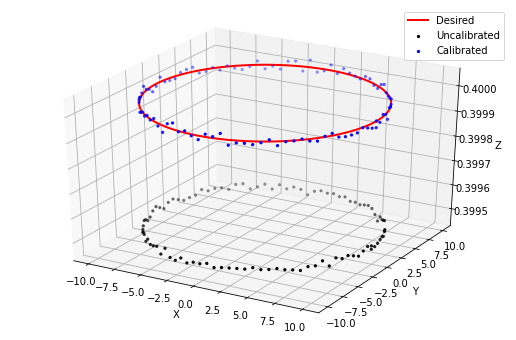

In [9]:
def PlotResults(desired, un_calibrated, calibrated):
    plt.figure(figsize=(9, 6))
    ax = plt.axes(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.plot3D(desired[0], desired[1], desired[2], c='red', linewidth=2, label='Desired')
    ax.scatter3D(un_calibrated[0], un_calibrated[1], un_calibrated[2], c='black', s=5, label='Uncalibrated')
    ax.scatter3D(calibrated[0], calibrated[1], calibrated[2], c='blue', s=5, label='Calibrated')

    ax.legend()
    plt.show()

PlotResults(desiredTrajectory, uncalibratedTrajectory, calibratedTrajectory)